In [ ]:
# composite_img <- img %>%
#   image_channel(channel = "blue") %>%
#   image_morphology(method = "Erode", kernel = "Disk") %>%
#   image_morphology(method = "Dilate", kernel = "Disk") %>%
#   image_fuzzycmeans() %>%
#   image_otsu() %>%
#   image_connect() %>%
#   image_split(keep_color = FALSE)  %>%
#   image_composite(img, operator = "Out")

In [11]:
import os

def get_all_filenames(output_dir):
    image_filenames = [os.path.join(output_dir, f) for f in os.listdir(output_dir)]
    image_filenames = [f for f in image_filenames if os.path.isfile(f)]

    return(image_filenames)

input_filenames = get_all_filenames("data\\new")
test_img_name = input_filenames[0]

print(test_img_name)

data\new\20210621_200137.jpg


In [8]:
import cv2
from skimage.color import rgb2gray
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import ndimage

In [9]:
def crop_and_rotate(img, ystart=0, yend=None, xstart=0, xend=None):
    if img.shape[0] > img.shape[1]:
        img = np.rot90(img)

    if yend is None:
        yend = img.shape[0]
    if xend is None:
        xend = img.shape[1]

    return img[ystart:yend, xstart:xend]


In [4]:
import ntpath

def apply_crop(img_filename, output_dir="data/new/cropped2/", xend=3250):
    os.makedirs(output_dir, exist_ok=True)
    img = plt.imread(img_filename)
    cropped_img = crop_and_rotate(img, xend=xend)

    filename = ntpath.basename(img_filename)
    save_filename = os.path.join(output_dir, filename)

    print(f"saving image to: {save_filename}")
    plt.imsave(save_filename, cropped_img)

# apply_crop(test_img_name)
# for img_name in input_filenames:
#     apply_crop(img_name)

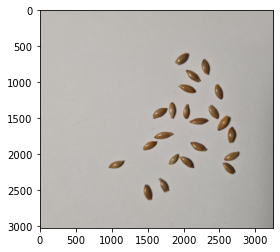

In [54]:
test_image_names = get_all_filenames("data\\new\\cropped")
start_image = plt.imread(test_image_names[0])

plt.imshow(start_image)

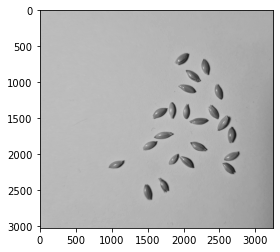

In [13]:
from numba import jit
import numpy as np

@jit(nopython=True)
def rgb_to_gray(img):
  x_dim = img.shape[1]
  y_dim = img.shape[0]
  return(np.array([[ img[y][x][0] for x in range(x_dim) ] for y in range(y_dim)]))

def remove_shadows(img, norm=True):
  rgb_planes = cv2.split(img)

  result_planes = []

  for plane in rgb_planes:
      dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
      bg_img = cv2.medianBlur(dilated_img, 21)
      diff_img = 255 - cv2.absdiff(plane, bg_img)

      # normalise if set
      if norm:
        diff_img = cv2.normalize(
            diff_img,
            None,
            alpha=0,
            beta=255,
            norm_type=cv2.NORM_MINMAX,
            dtype=cv2.CV_8UC1)

      result_planes.append(diff_img)

  return cv2.merge(result_planes)

gray_img = rgb_to_gray(start_image)
plt.imshow(gray_img, cmap="gray")

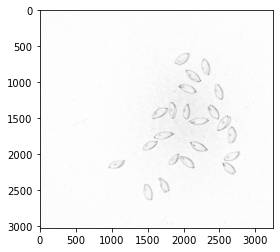

In [14]:
no_shadow = remove_shadows(gray_img)

plt.imshow((no_shadow), cmap="gray")

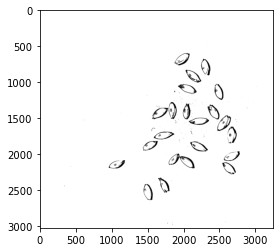

In [15]:
blurred = cv2.GaussianBlur(no_shadow, (5,5), 0)
otsu_mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

plt.imshow(otsu_mask, cmap="gray")

In [16]:
mask_outdir = "data\\new\\masks"
os.makedirs(mask_outdir, exist_ok=True)

plt.imsave(f"{mask_outdir}\\mask_1.jpg", otsu_mask)

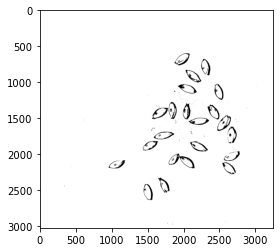

In [65]:
def mask_image(img):
    img_gray = rgb_to_gray(img)
    img_ns = remove_shadows(img_gray)
    img_blur = cv2.GaussianBlur(img_ns, (5,5), 0)

    img_otsu = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # filter out noise
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    img_erode = cv2.erode(img_otsu, element, iterations = 2)
    img_dilate = cv2.dilate(img_erode, element, iterations = 2)
    return(img_dilate)

plt.imshow(mask_image(start_image), cmap="gray")

In [66]:
for crp_imgfile in test_image_names:
    input_img = plt.imread(crp_imgfile)

    filename = ntpath.basename(crp_imgfile)
    save_filename = os.path.join(mask_outdir, filename)

    print(f"saving image to: {save_filename}")
    plt.imsave(save_filename, mask_image(input_img), cmap=plt.get_cmap("gray"))


saving image to: data\new\masks\20210621_200137.jpg
saving image to: data\new\masks\20210621_200154.jpg
saving image to: data\new\masks\20210621_200236.jpg
saving image to: data\new\masks\20210621_200552.jpg
saving image to: data\new\masks\20210621_200609.jpg
saving image to: data\new\masks\20210621_200713.jpg
saving image to: data\new\masks\20210621_200721.jpg
saving image to: data\new\masks\20210621_200844.jpg
saving image to: data\new\masks\20210621_200851.jpg
saving image to: data\new\masks\20210621_201002.jpg
saving image to: data\new\masks\20210621_201005.jpg
saving image to: data\new\masks\20210621_201204.jpg
saving image to: data\new\masks\20210621_201214.jpg
saving image to: data\new\masks\20210621_201301.jpg
saving image to: data\new\masks\20210621_201307.jpg
saving image to: data\new\masks\20210621_201439.jpg
saving image to: data\new\masks\20210621_201443.jpg
saving image to: data\new\masks\20210621_201508.jpg
saving image to: data\new\masks\20210621_201512.jpg
saving image